# SpikeInterface pipeline for Brody Lab

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import spikeextractors as se  # for reading raw data
import spiketoolkit as st  # pre- and post- processed, validation, and curation
import spikesorters as ss
import spikecomparison as sc  # ensemble sorting and spike train comparisons
import spikewidgets as sw  # visualizations

%matplotlib notebook

### Set global paramaters

In [2]:
n_jobs = 4  # Jobs for parallelization
chunk_mb = 2000  # RAM per job

verbose = True
use_memmap = False  # Enable memmap caching (recommended for Linux/macOS)

## 1a) Load AP recordings, LF recordings

In [3]:
base_path = Path("D:/Brody")
raw_data_path = base_path / "Chronic Rat Neuropixels (Poisson Clicks Task)" / "A242_2019_05_30" / "Raw"
session_name = "2019-05-30_g0"
ap_bin_path = raw_data_path / session_name / f"{session_name}_imec0" / f"{session_name}_t0.imec0.ap.bin"
lf_bin_path = ap_bin_path.parent / ap_bin_path.name.replace("ap", "lf")

### Make spikeinterface folders

In [4]:
recording_folder = raw_data_path / session_name
spikeinterface_folder = recording_folder / "spikeinterface"
spikeinterface_folder.mkdir(parents=True, exist_ok=True)

### (optional) stub recording for fast testing; set to False for running processing pipeline on entire data

In [5]:
stub_test = False
nsec_stub = 30  # seconds

In [6]:
recording_ap = se.SpikeGLXRecordingExtractor(ap_bin_path)
recording_lf = se.SpikeGLXRecordingExtractor(lf_bin_path)

if stub_test:
    recording_ap = se.SubRecordingExtractor(recording_ap, end_frame=int(nsec_stub*recording_ap.get_sampling_frequency()))
    recording_lf = se.SubRecordingExtractor(recording_lf, end_frame=int(nsec_stub*recording_lf.get_sampling_frequency()))

In [7]:
print(f"Sampling frequency AP: {recording_ap.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lf.get_sampling_frequency()}")

Sampling frequency AP: 30000.564435
Sampling frequency LF: 2500.04703625


### Inspect signals

In [ ]:
w_ts_ap = sw.plot_timeseries(recording_ap, channel_ids=recording_ap.get_channel_ids()[::10], trange=[1, 5])

In [ ]:
w_ts_lf = sw.plot_timeseries(recording_lf, channel_ids=recording_lf.get_channel_ids()[::10])

## 2) Pre-processing

In [8]:
apply_bandpass = True
apply_cmr = False  # Temporary until fix on spiketoolkits for SpikeGLX only

In [9]:
if apply_bandpass:
    recording_processed = st.preprocessing.bandpass_filter(recording_ap)
else:
    recording_processed = recording_ap

if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_processed)
else:
    recording_processed = recording_processed

In [ ]:
rates, amps = st.postprocessing.compute_channel_spiking_activity(
    start_frame=0,
    end_frame=recording_processed.get_num_frames(), 
    detect_threshold=5,
    recompute_info=True,
    recording=recording_processed,
    n_jobs=n_jobs,
    chunk_mb=chunk_mb,
    verbose=verbose
)

In [ ]:
fig, axs = plt.subplots(nrows=2)
sw.plot_activity_map(recording_processed, activity="rate", colorbar=True, ax=axs[0], transpose=True, colorbar_orientation="horizontal")
sw.plot_activity_map(recording_processed, activity="amplitude", colorbar=True, ax=axs[1], transpose=True, colorbar_orientation="horizontal")

## 3) Run spike sorters

In [10]:
sorter_list = [
    "herdingspikes",
    "tridesclous",
    #"ironclust",
]

#ss.IronClustSorter.set_ironclust_path("D:/GitHub/ironclust")

In [11]:
# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))    

herdingspikes params description:
{'ahpthr': 'Requires magnitude of spike rebound for acceptance',
 'amp_evaluation_time': 'Amplitude evaluation time (ms)',
 'clustering_alpha': 'Scalar for the waveform PC features when clustering.',
 'clustering_bandwidth': 'Meanshift bandwidth, average spatiel extent of spike '
                         'clusters (um)',
 'clustering_bin_seeding': 'Enable clustering bin seeding.',
 'clustering_min_bin_freq': 'Minimum spikes per bin for bin seeding.',
 'clustering_n_jobs': 'Number of cores to use for clustering.',
 'clustering_subset': 'Number of spikes used to build clusters. All by '
                      'default.',
 'decay_filtering': 'Experimental: Set to True at your risk',
 'detect_threshold': 'Detection threshold',
 'filter': 'Enable or disable filter',
 'filter_duplicates': 'Remove spike duplicates (based on spk_evaluation_time)',
 'freq_max': 'Low-pass filter cutoff frequency',
 'freq_min': 'High-pass filter cutoff frequency',
 'left_cutout_ti

In [12]:
# user-specific parameters
sorter_params = dict(
    herdingspikes=dict(filter=False),
    tridesclous=dict(n_jobs_bin=n_jobs, chunk_mb=chunk_mb)
    #ironclust=dict(n_jobs_bin=n_jobs, chunk_mb=chunk_mb)
)

In [13]:
sorting_outputs = ss.run_sorters(
    sorter_list=sorter_list, 
    recording_dict_or_list=dict(rec0=recording_processed),
    working_folder=spikeinterface_folder / "working1",
    mode="keep", # change to "keep" to avoid repeating the spike sorting
    sorter_params=sorter_params,
    verbose=verbose,
    run_sorter_kwargs=dict(raise_error=False)
)

Local copy of recording
DataIO <id: 1679716545440> 
  workdir: D:\Brody\Chronic Rat Neuropixels (Poisson Clicks Task)\A242_2019_05_30\Raw\2019-05-30_g0\spikeinterface\working1\rec0\tridesclous
  sample_rate: 30000.564435
  total_channel: 384
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch380 ch381 ch382 ch383]
  nb_segment: 1
  length: 333351226
  durations: 11111.5 s.
catalogue_nested_params
{'chunksize': 30000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': True,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 50.0,
                   'high_adjacency_radius_um': 30.0,
                   'max_loop': 7680,
                   'min_cluster_size': 20},
 'cluster_method': 'pruningshears',
 'duration': 601.0,
 'extract_wa

In [14]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    print(f"{sorter} found {len(sorting.get_unit_ids())} units")
    
    # tridesclous sometimes has empty clusters
    active_units = []
    for u in sorting.get_unit_ids():
        if len(sorting.get_unit_spike_train(u)) > 0:
            active_units.append(u)
    
    if len(active_units) < len(sorting.get_unit_ids()):
        sorting_outputs[result_name] = se.SubSortingExtractor(sorting, unit_ids=active_units)
        print(f"{sorter} found {len(active_units)} units after removing empty")

herdingspikes found 51 units


## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features

### Set quality metric list
#### Reference: https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html

In [15]:
print(f"Available quality metrics: {st.validation.get_quality_metrics_list()}")

Available quality metrics: ['num_spikes', 'firing_rate', 'presence_ratio', 'isi_violation', 'amplitude_cutoff', 'snr', 'max_drift', 'cumulative_drift', 'silhouette_score', 'isolation_distance', 'l_ratio', 'd_prime', 'noise_overlap', 'nn_hit_rate', 'nn_miss_rate']


In [16]:
# Specify a subset of these metrics
qm_list = ['snr', 'isi_violation', 'firing_rate']

### Set extracellular features
#### Reference: https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms

In [17]:
print(f"Available quality metrics: {st.postprocessing.get_template_features_list()}")

Available quality metrics: ['peak_to_valley', 'halfwidth', 'peak_trough_ratio', 'repolarization_slope', 'recovery_slope']


In [18]:
# Specify a subset of these features
ecf_list = ['peak_to_valley', 'halfwidth']

### Set postprocessing parameters

In [19]:
postprocessing_params = st.postprocessing.get_postprocessing_params()
pprint(f"Default parameters: {postprocessing_params}")

("Default parameters: {'grouping_property': None, 'ms_before': 3.0, "
 "'ms_after': 3.0, 'dtype': None, 'compute_property_from_recording': False, "
 "'n_jobs': None, 'max_channels_per_waveforms': None, 'method': 'absolute', "
 "'peak': 'both', 'frames_before': 3, 'frames_after': 3, 'n_comp': 3, "
 "'by_electrode': True, 'max_spikes_for_pca': 5000, 'whiten': False, "
 "'max_spikes_per_unit': 300, 'recompute_info': False, "
 "'save_property_or_features': True, 'memmap': True, 'seed': 0, 'verbose': "
 "False, 'joblib_backend': 'loky'}")


In [20]:
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted
postprocessing_params['n_jobs'] = n_jobs
postprocessing_params['chunk_mb'] = chunk_mb
postprocessing_params['verbose'] = verbose
postprocessing_params['recompute_info'] = True
postprocessing_params['memmap'] = use_memmap

export_to_phy = False

### Postprocess all sorting outputs

In [21]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    print(f"Postprocessing recording {rec_name} sorted with {sorter}")
    tmp_folder = spikeinterface_folder / 'tmp' / sorter
    tmp_folder.mkdir(parents=True, exist_ok=True)
    
    # set local tmp folder
    sorting.set_tmp_folder(tmp_folder)
    
    # compute waveforms
    waveforms = st.postprocessing.get_unit_waveforms(recording_processed, sorting, **postprocessing_params)
    
    # compute templates
    templates = st.postprocessing.get_unit_templates(recording_processed, sorting, **postprocessing_params)
    
    # compute metrics
    qm = st.validation.compute_quality_metrics(
        sorting,
        recording=recording_processed, 
        metric_names=qm_list,
        as_dataframe=True
    )
    
    # compute features
    ecf = st.postprocessing.compute_unit_template_features(
        recording_processed,
        sorting,
        feature_names=ecf_list,
        as_dataframe=True
    )
    
    # export to phy - can be expensive, disable if not used
    if export_to_phy:
        phy_folder = spikeinterface_folder / 'phy' / sorter
        phy_folder.mkdir(parents=True, exist_ok=True)
        st.postprocessing.export_to_phy(
            recording_processed,
            sorting,
            phy_folder,
            compute_pc_features=False,
            compute_amplitudes=False,
            save_property_or_features=False
        )

Postprocessing recording rec0 sorted with herdingspikes
Number of chunks: 1025 - Number of jobs: 4
Number of chunks: 1025 - Number of jobs: 4


In [22]:
display(qm)

,firing_rate,isi_violation,snr
0,10.076859,0.002091,8.230719
1,7.631734,0.315114,4.603617
2,4.547721,0.332964,4.757054
3,0.579490,0.000000,6.538349
4,0.632498,0.075830,4.026287
5,0.653917,2.270194,4.420410
6,0.585160,0.000000,6.937413
7,0.344328,0.511734,7.839980
8,0.193133,0.813288,5.184810
9,0.649147,0.143980,7.874777


In [23]:
display(ecf)

,peak_to_valley,halfwidth
0,0.000367,0.000200
1,0.000433,0.000200
2,0.000433,0.000167
3,0.000200,0.000133
4,0.000600,0.000233
5,0.000733,0.000600
6,0.000267,0.000267
7,0.000300,0.000300
8,0.000700,0.000233
9,0.000267,0.000300


### Visualize templates

<IPython.core.display.Javascript object>


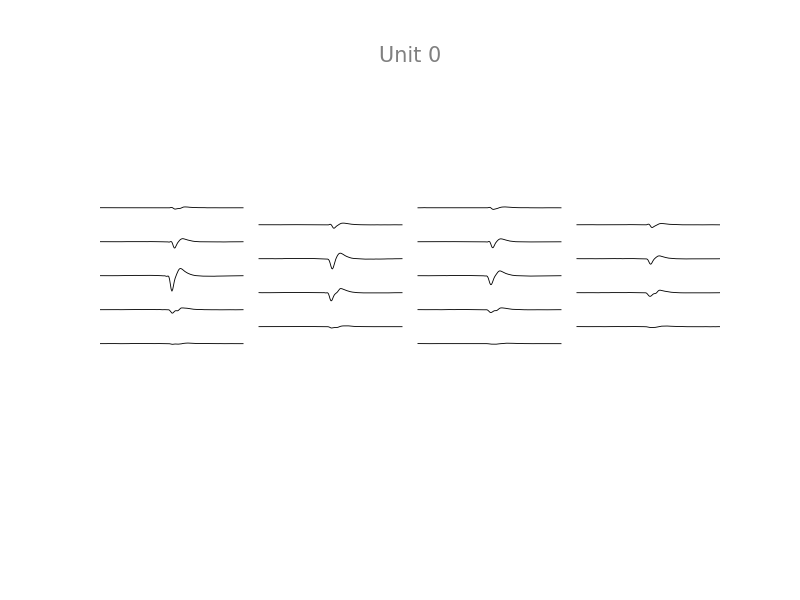

In [24]:
sorting_ic = sorting_outputs[("rec0", "herdingspikes")]
w = sw.plot_unit_templates(
    recording_processed,
    sorting_ic,
    unit_ids=[0],
    radius=100,  # This is spatial distance specifying channels around the unit - default is None
    lw=0.5
)
#w.figure.set_size_inches((5,15))  # this can be handy if radius=None above, to give a better visual of probe laayout

### Run phy and load curated data

####  Reference: https://phy.readthedocs.io/en/latest/

In [ ]:
!phy template-gui spikeinterface/phy/ironclust/params.py

In [ ]:
sorting_manual_curated = se.PhySortingExtractor(phy_folder, exclude_cluster_groups=['noise'])

In [ ]:
print(f"ironclust found {len(sorting_manual_curated.get_unit_ids())} units after manual curation")

## 5) Ensemble spike sorting

#### If using more than one spike sorter, this automated method has been shown to give similar results to manual curation under certain conditions: https://elifesciences.org/articles/61834

In [ ]:
if len(sorting_outputs) > 1:
    # retrieve sortings and sorter names
    sorting_list = []
    sorter_names_comp = []
    for result_name, sorting in sorting_outputs.items():
        rec_name, sorter = result_name
        sorting_list.append(sorting)
        sorter_names_comp.append(sorter)
        
    # run multisorting comparison
    mcmp = sc.compare_multiple_sorters(sorting_list=sorting_list, name_list=sorter_names_comp)
    
    # plot agreement results
    w_agr = sw.plot_multicomp_agreement(mcmp)
    
    # extract ensamble sorting
    sorting_ensemble = mcmp.get_agreement_sorting(minimum_agreement_count=2)
    
    print(f"Ensemble sorting among {sorter_list} found: {len(sorting_ensemble.get_unit_ids())} units")
    sw.plot_rasters(sorting_ensemble)

# 6) Automatic curation

In [25]:
firing_rate_threshold = 0.1
isi_violation_threshold = 0.5
snr_threshold = 3

In [ ]:
sorting_auto_curated = []
sorter_names_curation = []
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    sorter_names_curation.append(sorter)
    
    # firing rate threshold
    sorting_curated = st.curation.threshold_firing_rates(
        sorting,
        duration_in_frames=recording_processed.get_num_frames(),
        threshold=firing_rate_threshold, 
        threshold_sign='less'
    )
    print(f"{sorter} found {len(sorting_curated.get_unit_ids())} units after thresholding firing rates")
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_isi_violations(
        sorting_curated,
        duration_in_frames=recording_processed.get_num_frames(),
        threshold=isi_violation_threshold, 
        threshold_sign='greater'
    )
    print(f"{sorter} found {len(sorting_curated.get_unit_ids())} units after thresholding isi violations")
    
    # snr threshold
    sorting_curated = st.curation.threshold_snrs(
        sorting_curated,
        recording=recording_processed,
        threshold=snr_threshold, 
        threshold_sign='less'
    )
    sorting_auto_curated.append(sorting_curated)
    print(f"{sorter} found {len(sorting_curated.get_unit_ids())} units after thresholding snr")

herdingspikes found 20 units after thresholding firing rates
herdingspikes found 15 units after thresholding isi violations


# 7) Save to NWB; writes only the spikes

In [ ]:
# The name of the NWBFile containing behavioral and/or full recording data
nwbfile_path = base_path.parent / f"Brody_PoissonClicks_{session_name}_full_autocurated.nwb"

# Choose the sorting extractor from the notebook environment you would like to write to NWB
#chosen_sorting_extractor = sorting_outputs[("rec0", "tridesclous")]
chosen_sorting_extractor = sorting_curated

se.NwbSortingExtractor.write_sorting(
    sorting=chosen_sorting_extractor,
    save_path=nwbfile_path,
    overwrite=True,  # this appends the file. True would write a new file,
    skip_features=["waveforms"]
)